In [8]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt

In [2]:
#load data and resize to 224,224 by class depending on folder name
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train = train_datagen.flow_from_directory(os.getcwd()+'/data/train/',
                                                    target_size = (224, 224),
                                                    batch_size = 16,
                                                    class_mode = 'categorical')

valid = train_datagen.flow_from_directory(os.getcwd()+'/data/valid/',
                                                    target_size = (224, 224),
                                                    batch_size = 16,
                                                    class_mode = 'categorical')

test = test_datagen.flow_from_directory(os.getcwd()+'/data/test/',
                                                    target_size = (224, 224),
                                                    batch_size = 16,
                                                    class_mode = 'categorical')

Found 1656 images belonging to 2 classes.
Found 55 images belonging to 2 classes.
Found 99 images belonging to 2 classes.


In [3]:
#load model
vgg16=tf.keras.applications.vgg16.VGG16(weights='imagenet',include_top=False,input_shape=(224, 224, 3))

In [4]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
# freeze layers
# for l in vgg16.layers:
#   l.trainable = False

In [6]:
#create model from frozen layer except last layer because it works on 1000 classes and instead make it classify 2 classes
model=tf.keras.Sequential()

# for l in vgg16.layers[:-1]:
#   model.add(l)
model.add(vgg16)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 21,137,986
Trainable params: 21,137,986
Non-trainable params: 0
_________________________________________________________________


In [7]:
with tf.device('/gpu:0'):
  hist=model.fit(train,validation_data=valid,epochs=10,batch_size=16,verbose=1)

Epoch 1/10
104/104 [==============================] - 75s 517ms/step - loss: 66.7738 - accuracy: 0.5483 - val_loss: 0.7306 - val_accuracy: 0.4545
Epoch 2/10
104/104 [==============================] - 45s 428ms/step - loss: 0.6919 - accuracy: 0.5688 - val_loss: 0.6789 - val_accuracy: 0.6364
Epoch 3/10
104/104 [==============================] - 45s 437ms/step - loss: 0.9531 - accuracy: 0.5513 - val_loss: 0.8319 - val_accuracy: 0.4182
Epoch 4/10
104/104 [==============================] - 46s 441ms/step - loss: 0.6756 - accuracy: 0.5876 - val_loss: 0.6793 - val_accuracy: 0.5273
Epoch 5/10
104/104 [==============================] - 47s 448ms/step - loss: 0.6676 - accuracy: 0.6087 - val_loss: 0.6117 - val_accuracy: 0.6364
Epoch 6/10
104/104 [==============================] - 49s 469ms/step - loss: 0.6528 - accuracy: 0.6395 - val_loss: 0.6292 - val_accuracy: 0.6909
Epoch 7/10
104/104 [==============================] - 49s 469ms/step - loss: 0.6349 - accuracy: 0.6522 - val_loss: 0.6112 - val_a

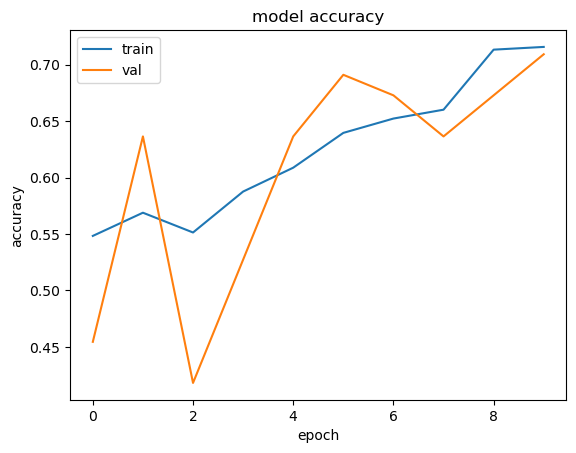

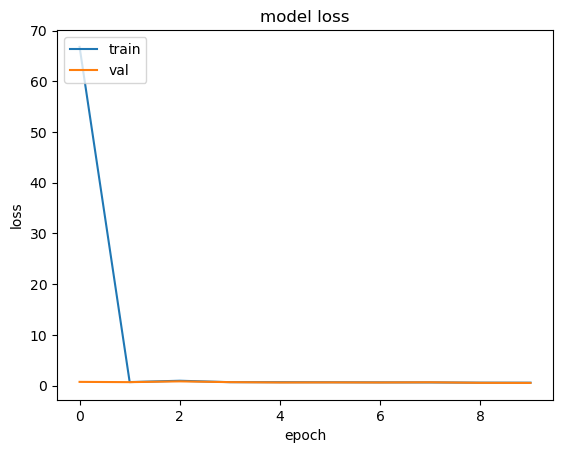

1/1 [==============================] - 0s 206ms/step - loss: 0.7141 - accuracy: 0.6875
Test-set classification accuracy: 68.75%


In [15]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

result = model.evaluate(test, steps=1)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

In [13]:
model.save(os.getcwd()+"/model.h5")